In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from pdpbox import pdp, info_plots
from sklearn.model_selection import KFold

%matplotlib inline

## データ読込

In [2]:
dataset_url = 'https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv'
user_df = pd.read_csv(dataset_url)

In [3]:
user_df.head()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0


## CMを見た人、見ていない人の平均ゲーム利用時間

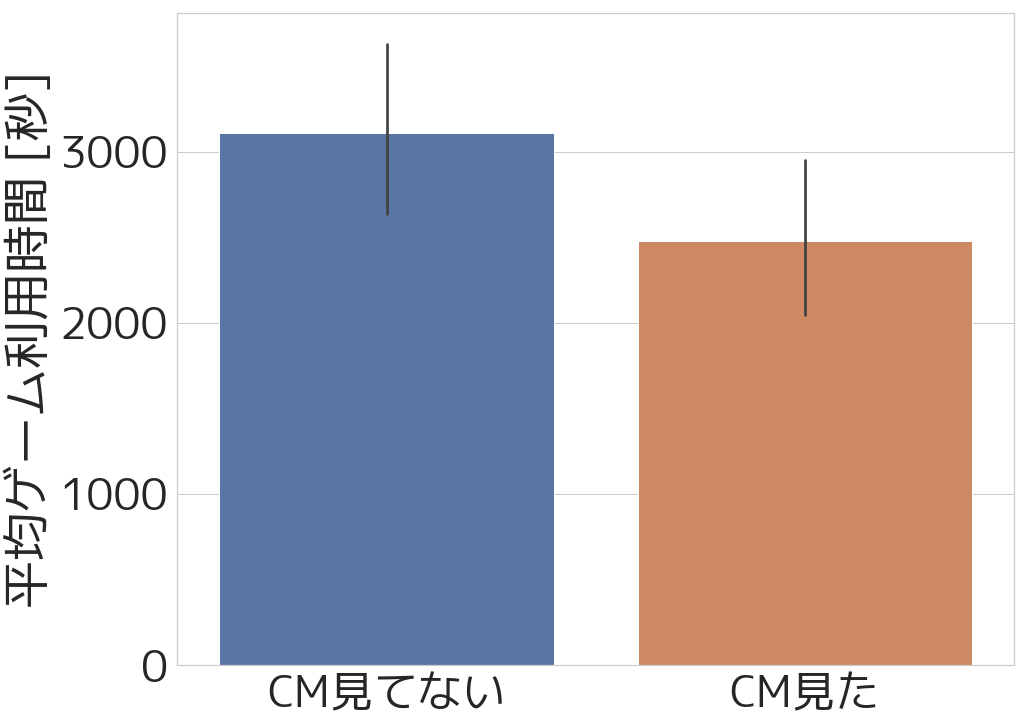

In [4]:
target = 'gamesecond'

sns.set(style="whitegrid", font_scale=4)
fig = plt.figure(figsize=[15,12])
ax = fig.add_subplot(1, 1, 1)
ax = sns.barplot(x='cm_dummy', y=target, data=user_df, ax=ax)
ax.set_xticklabels(['CM見てない', 'CM見た'])
ax.set_xlabel('')
ax.set_ylabel('平均ゲーム利用時間 [秒]')
plt.savefig('./fig/fig_1.png', dpi=300, bbox_inches="tight")

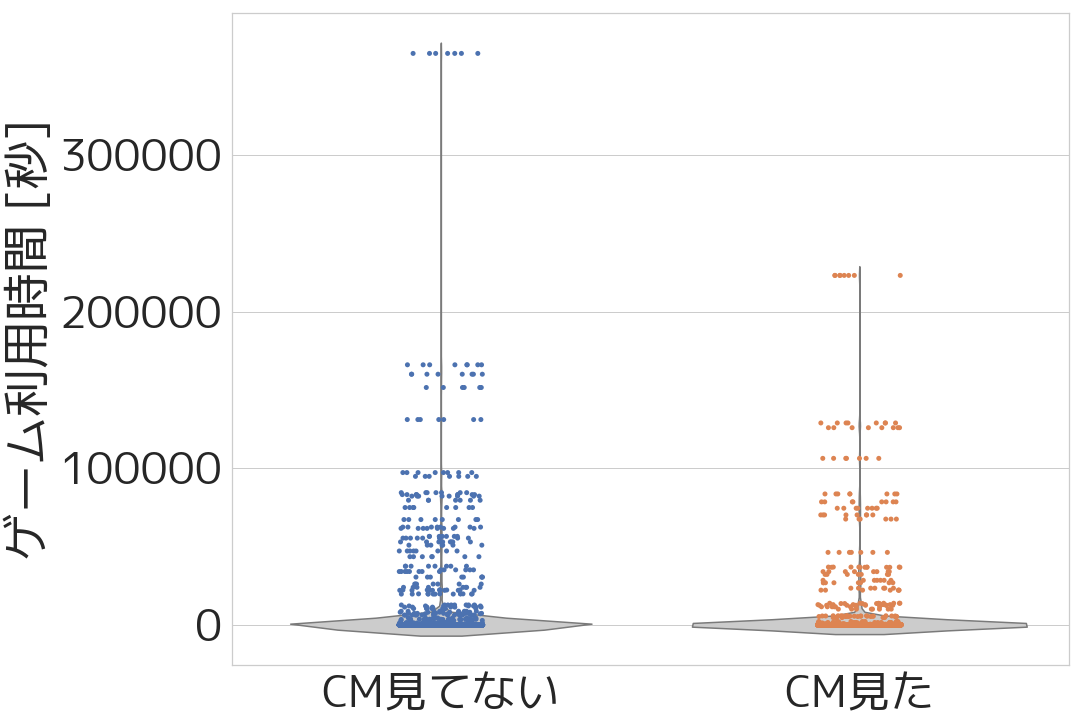

In [6]:
sns.set(style="whitegrid", font_scale=4)
fig = plt.figure(figsize=[15,12])
ax = fig.add_subplot(1, 1, 1)
ax = sns.stripplot(x='cm_dummy', y=target, data=user_df, ax=ax)
ax = sns.violinplot(x='cm_dummy', y=target, data=user_df, ax=ax, inner=None, color='.8')
ax.set_xticklabels(['CM見てない', 'CM見た'])
ax.set_xlabel('')
ax.set_ylabel('ゲーム利用時間 [秒]')
plt.savefig('./fig/fig_2.png', dpi=300, bbox_inches="tight")

## ゲーム利用時間予測モデルの作成
* 10 folds CV  
* LightGBM

In [7]:
targets = ['gamecount', 'gamedummy', 'gamesecond']

In [35]:
X = user_df.drop(targets, axis=1)
y = user_df.gamesecond

evals = []
models = []

kf = KFold(n_splits=10, shuffle=True, random_state=0)
for train_index, valid_index in kf.split(X):
    X_train, y_train = X.values[train_index], y.values[train_index]
    X_valid, y_valid = X.values[valid_index], y.values[valid_index]
    
    # training
    model = lgb.LGBMRegressor(n_estimators=100000, objective='rmse')
    model.fit(
        X_train,
        y_train,
        eval_set=(X_valid, y_valid),
        eval_metric='rmse',
        early_stopping_rounds=1000,
        verbose=1000
    )
    # eval
    y_pred = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    evals.append(rmse)
    print(f'train RMSE: {np.sqrt(mean_squared_error(y_train, model.predict(X_train)))}')
    print(f'valid RMSE: {rmse}')
    models.append(model)

Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's rmse: 704.848
[2000]	valid_0's rmse: 302.699
[3000]	valid_0's rmse: 226.094
[4000]	valid_0's rmse: 206.986
[5000]	valid_0's rmse: 200.682
[6000]	valid_0's rmse: 198.91
[7000]	valid_0's rmse: 198.313
[8000]	valid_0's rmse: 198.131
[9000]	valid_0's rmse: 198.028
[10000]	valid_0's rmse: 197.878
[11000]	valid_0's rmse: 197.842
[12000]	valid_0's rmse: 197.82
[13000]	valid_0's rmse: 197.811
[14000]	valid_0's rmse: 197.81
[15000]	valid_0's rmse: 197.809
Early stopping, best iteration is:
[14375]	valid_0's rmse: 197.806
train RMSE: 27.69330298633984
valid RMSE: 197.8064146005138
Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's rmse: 1263.18
[2000]	valid_0's rmse: 458.735
[3000]	valid_0's rmse: 175.2
[4000]	valid_0's rmse: 91.3155
[5000]	valid_0's rmse: 58.0317
[6000]	valid_0's rmse: 45.6847
[7000]	valid_0's rmse: 40.5642
[8000]	valid_0's rmse: 39.0236
[9000]	valid_0's rmse: 38.4326


In [36]:
evals

[197.8064146005138,
 38.08348004611209,
 177.69868814029323,
 48.679670819373676,
 181.33848604221336,
 34.038833548525105,
 53.719293310652965,
 93.0215493365826,
 74.01689255292278,
 72.35423822123049]

In [40]:
np.mean(evals)

97.07575466184201

## Partial Dependence Plot
* 全員がCMを見てないときのゲーム利用時間を予測
* 全員がCMを見たときのゲーム利用時間を予測  
→どれくらいゲーム利用時間が異なるのかを可視化する  
10 foldsの10モデルにおけるPDP差分（PDDと命名）を比較する

1モデルのPDPを可視化

In [13]:
sns.set(font_scale=1, style='whitegrid')

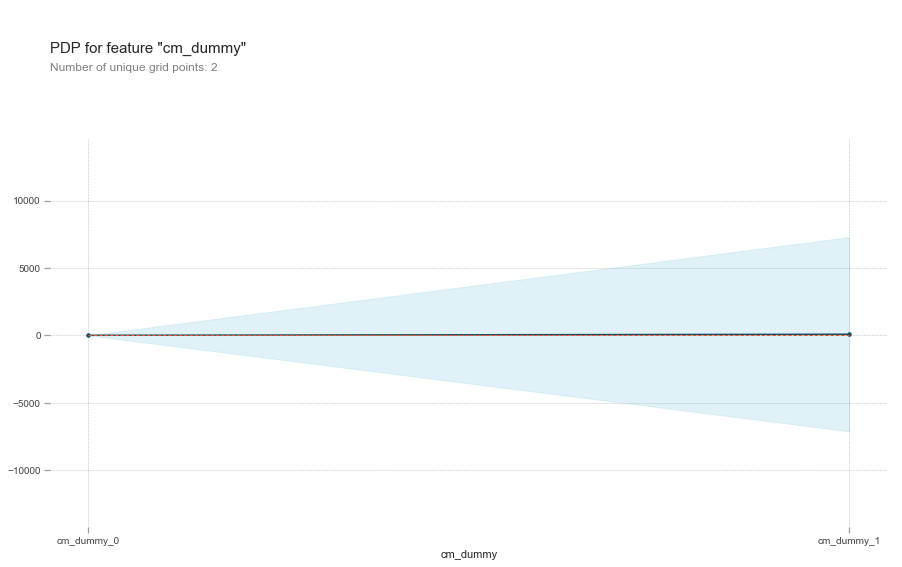

In [42]:
pdp_cm = pdp.pdp_isolate(
    model=models[0], dataset=pdp_df, model_features=X.columns.tolist(), feature='cm_dummy'
)
fig, axes = pdp.pdp_plot(pdp_cm, 'cm_dummy')#, plot_lines=True, frac_to_plot=0.5, plot_pts_dist=True)

In [37]:
pdp_df = pd.concat([X, y], axis=1)
tmp = pdp_df.copy()
tmp.loc[:, 'cm_dummy'] = 1
positive_df = tmp.copy()
tmp.loc[:, 'cm_dummy'] = 0
negative_df = tmp.copy()

In [38]:
def get_pdd(model):
    pos_pred = model.predict(positive_df.drop('gamesecond', axis=1))
    neg_pred = model.predict(negative_df.drop('gamesecond', axis=1))
    pdd = pos_pred.mean() - neg_pred.mean()
    print(f'PDD: {pdd}')
    return pdd

In [39]:
pdds = []
for model in models:
    pdds.append(get_pdd(model))

PDD: 79.46672070206796
PDD: 256.5786981817578
PDD: 120.04346964408342
PDD: 178.0384604222818
PDD: -104.1517957352653
PDD: 395.651670016091
PDD: -19.759553113782204
PDD: 158.73386464858504
PDD: 414.4079474939517
PDD: 397.6521207803944


In [43]:
np.mean(pdds)

187.66616030401656

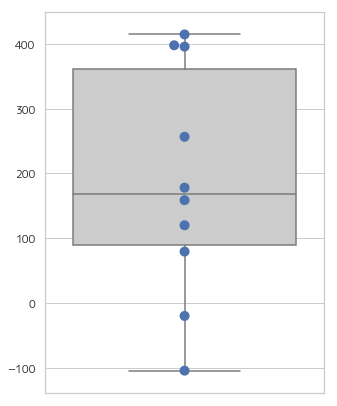

In [54]:
plt.figure(figsize=[5, 7])
sns.set(font_scale=1, style='whitegrid')
sns.boxplot(x=pdds, color='.8', orient='v')
sns.swarmplot(x=pdds, orient='v', size=10)

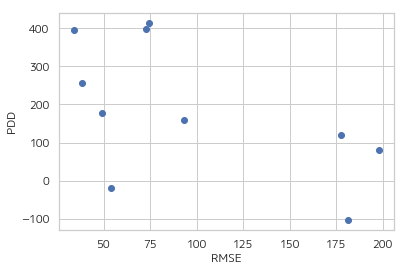

In [57]:
plt.scatter(evals, pdds)
plt.xlabel('RMSE')
plt.ylabel('PDD');

RMSEが低い（精度が高い）ほど、PDDが高いかもしれない?

## corr

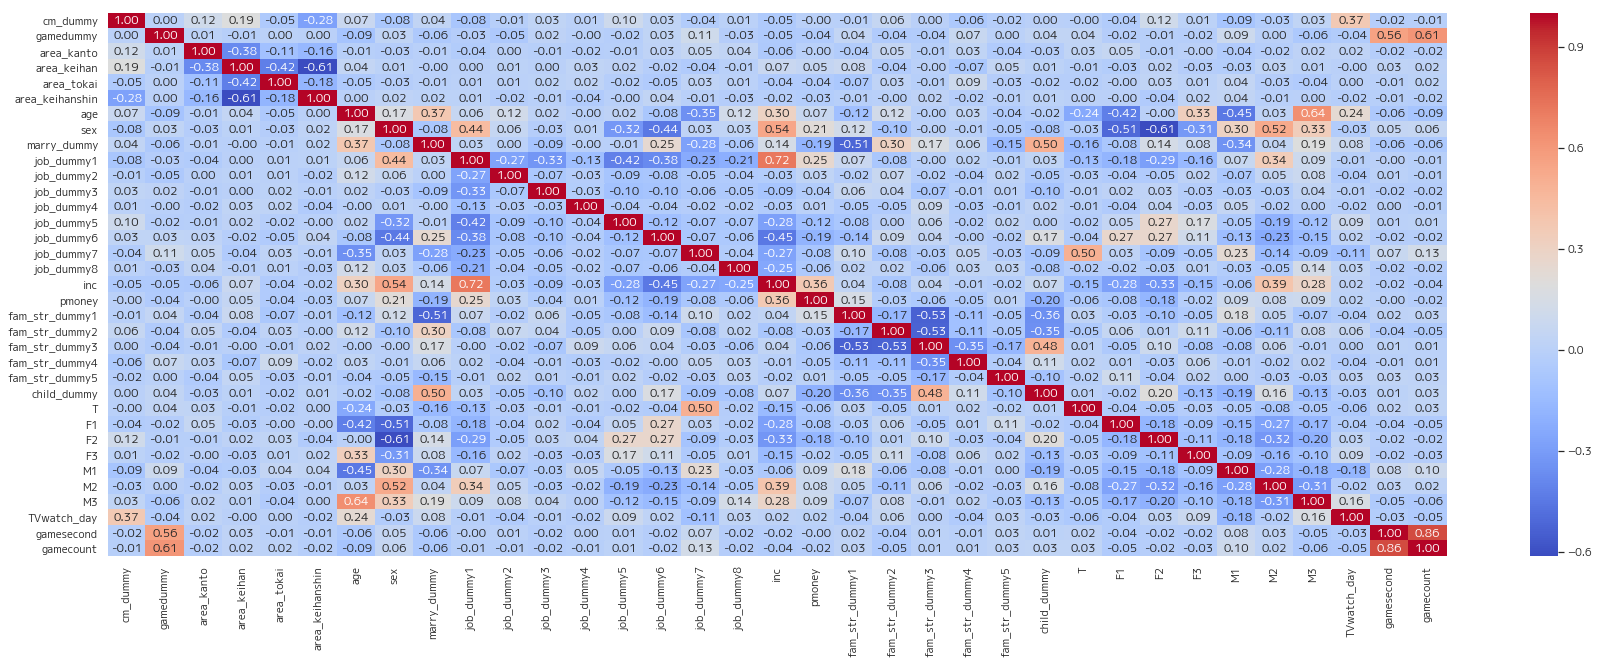

In [21]:
corr_df = user_df.corr()
plt.figure(figsize=[30, 10])
sns.heatmap(corr_df, cmap='coolwarm', annot=True, fmt='.2f')

## feature importance

In [71]:
ftis = np.zeros((len(models), len(X.columns)))
for i, model in enumerate(models):
    ftis[i, :] = model.feature_importances_

In [74]:
mean_importance = ftis.mean(axis=0)

In [82]:
fti_df = pd.DataFrame({
    'column_name': X.columns.tolist(),
    'importance': mean_importance
})
fti_df = fti_df.sort_values('importance', ascending=True).reset_index(drop=True)

<BarContainer object of 32 artists>

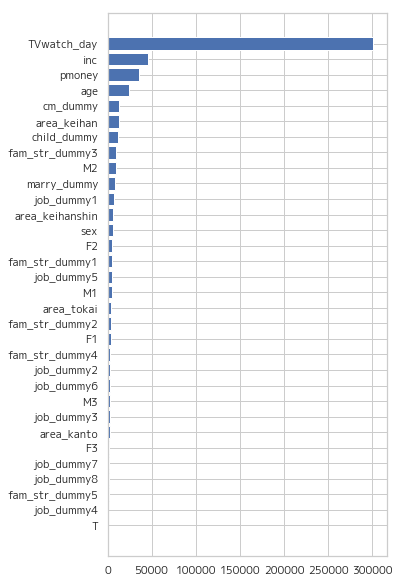

In [90]:
plt.figure(figsize=(5, 10))
plt.barh(fti_df.column_name, fti_df.importance, )

## Partial Dependence Plot (2-D)

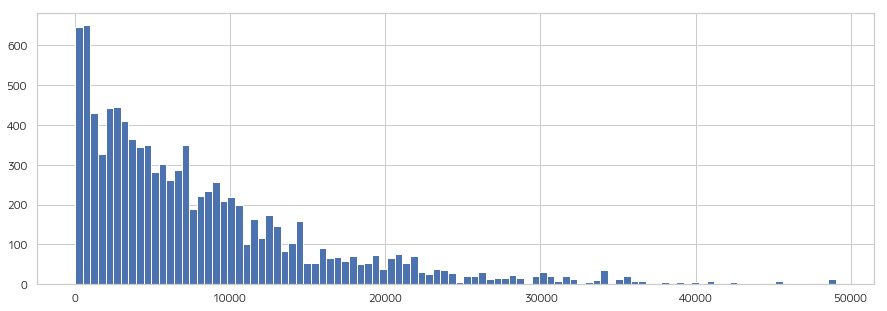

In [65]:
plt.figure(figsize=[15, 5])
plt.hist(pdp_df.TVwatch_day, bins=100);

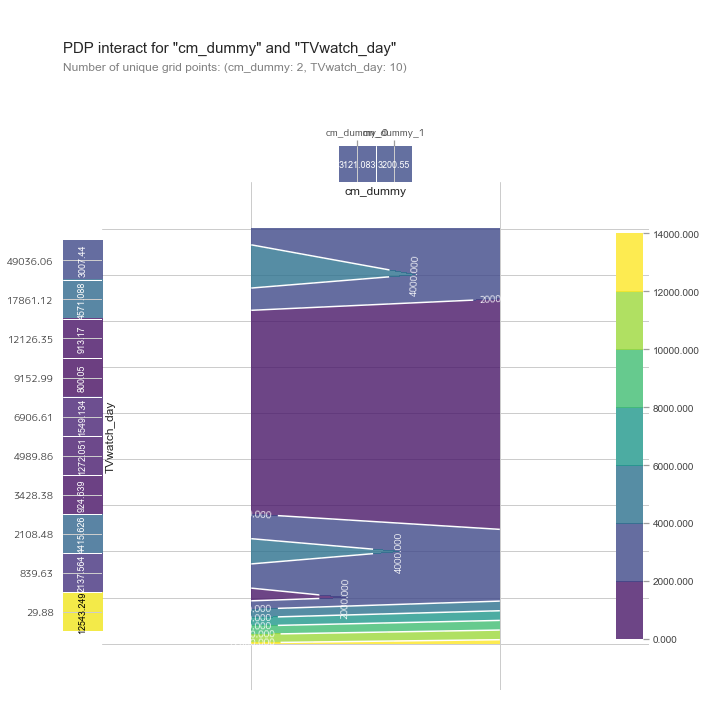

In [59]:
inter1 = pdp.pdp_interact(
    model=models[0], dataset=pdp_df, model_features=X.columns.tolist(), features=['cm_dummy', 'TVwatch_day']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=inter1, feature_names=['cm_dummy', 'TVwatch_day'], plot_type='contour', x_quantile=True, plot_pdp=True
)

## 資料用サンプルデータ表示

In [136]:
hoge = pdp_df.sample(10).reset_index(drop=True)
hoge[['gamesecond', 'cm_dummy', 'age', 'sex', 'marry_dummy']]

,gamesecond,cm_dummy,age,sex,marry_dummy
0,0,0,24.5,0,1
1,35121,0,44.5,0,1
2,0,0,44.5,1,0
3,1367,0,34.5,0,1
4,0,1,44.5,0,1
5,0,1,34.5,0,1
6,0,0,34.5,1,0
7,0,0,34.5,0,0
8,0,0,34.5,0,1
9,0,1,60.0,1,1


In [163]:
hoge.loc[:, 'cm_dummy'] = 0
hoge[['gamesecond', 'cm_dummy', 'age', 'sex', 'marry_dummy']]

,gamesecond,cm_dummy,age,sex,marry_dummy
0,0,0,24.5,0,1
1,35121,0,44.5,0,1
2,0,0,44.5,1,0
3,1367,0,34.5,0,1
4,0,0,44.5,0,1
5,0,0,34.5,0,1
6,0,0,34.5,1,0
7,0,0,34.5,0,0
8,0,0,34.5,0,1
9,0,0,60.0,1,1


In [164]:
sample_pred = models[0].predict(hoge.drop(['gamesecond', 'pred', 'pred_pos', 'pred_neg'], axis=1))

In [165]:
hoge['pred_neg'] = sample_pred

In [166]:
hoge[['gamesecond', 'cm_dummy', 'age', 'sex', 'marry_dummy', 'pred_neg']]

,gamesecond,cm_dummy,age,sex,marry_dummy,pred_neg
0,0,0,24.5,0,1,-0.006649
1,35121,0,44.5,0,1,35119.290231
2,0,0,44.5,1,0,-0.115636
3,1367,0,34.5,0,1,1367.436411
4,0,0,44.5,0,1,5594.932936
5,0,0,34.5,0,1,-101.731216
6,0,0,34.5,1,0,-0.095350
7,0,0,34.5,0,0,0.057964
8,0,0,34.5,0,1,0.000507
9,0,0,60.0,1,1,-373.038837


In [167]:
hoge.loc[:, 'cm_dummy'] = 1
hoge[['gamesecond', 'cm_dummy', 'age', 'sex', 'marry_dummy']]

,gamesecond,cm_dummy,age,sex,marry_dummy
0,0,1,24.5,0,1
1,35121,1,44.5,0,1
2,0,1,44.5,1,0
3,1367,1,34.5,0,1
4,0,1,44.5,0,1
5,0,1,34.5,0,1
6,0,1,34.5,1,0
7,0,1,34.5,0,0
8,0,1,34.5,0,1
9,0,1,60.0,1,1


In [168]:
sample_pred = models[0].predict(hoge.drop(['gamesecond', 'pred', 'pred_pos', 'pred_neg'], axis=1))
hoge['pred_pos'] = sample_pred
hoge[['gamesecond', 'cm_dummy', 'age', 'sex', 'marry_dummy', 'pred_neg', 'pred_pos']]

,gamesecond,cm_dummy,age,sex,marry_dummy,pred_neg,pred_pos
0,0,1,24.5,0,1,-0.006649,-2470.942813
1,35121,1,44.5,0,1,35119.290231,34650.832534
2,0,1,44.5,1,0,-0.115636,296.440564
3,1367,1,34.5,0,1,1367.436411,504.029297
4,0,1,44.5,0,1,5594.932936,-0.063001
5,0,1,34.5,0,1,-101.731216,-0.036976
6,0,1,34.5,1,0,-0.095350,-2510.056482
7,0,1,34.5,0,0,0.057964,-1855.376640
8,0,1,34.5,0,1,0.000507,4059.987168
9,0,1,60.0,1,1,-373.038837,0.001765
